In [6]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [7]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [8]:


# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)


# Parâmetros adicionais
t = 14
d = 30
e = 14
# Lista de parâmetros n para iterar
n_list = [ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]  # Exemplo de diferentes valores de n
alpha = 0.20  # Mantemos um único valor de alpha



price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Loop para calcular o RSI para cada valor em 'n_list'
for n in n_list:
    # Dias de alta e dias de baixa
    up_df, down_df = price_data[['Ticker', 'change_in_price']].copy(), price_data[['Ticker', 'change_in_price']].copy()

    # Salvando a diferença para dias de alta
    up_df.loc[up_df['change_in_price'] < 0, 'change_in_price'] = 0

    # Salvando a diferença para dias de baixa
    down_df.loc[down_df['change_in_price'] > 0, 'change_in_price'] = 0

    # Colocando as diferenças do dia de baixa em termos absolutos
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculando o EWMA (Exponential Weighted Moving Average) para dias de alta e baixa
    ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())
    ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())

    # Calculando o Relative Strength (RS)
    relative_strength = ewma_up / ewma_down

    # Calculando o Relative Strength Index (RSI)
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Salvando o RSI como uma nova coluna no dataframe
    price_data[f'RSI_{n}'] = relative_strength_index

    # Salvando colunas auxiliares para verificação (opcional)
    price_data[f'down_days_{n}'] = down_df['change_in_price']
    price_data[f'up_days_{n}'] = up_df['change_in_price']


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd



# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_6,down_days_6,up_days_6,RSI_7,down_days_7,up_days_7,RSI_8,down_days_8,up_days_8,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
11749,2024-12-04,58.400002,58.480000,56.959999,57.330002,56.822830,25109200,VALE3.SA,-1.139999,58.150667,-1.0,29.088326,1.139999,0.000000,31.727524,1.139999,0.000000,33.623181,1.139999,0.000000,34.995447,1.139999,0.000000,36.001861,1.139999,0.000000,36.753881,1.139999,0.000000,37.329610,1.139999,0.000000,37.783422,1.139999,0.000000,38.153023,1.139999,0.000000,38.464494,1.139999,0.000000,38.735836,1.139999,0.000000,38.979435,1.139999,0.000000,39.203777,1.139999,0.000000,39.414628,1.139999,0.000000,39.615869,1.139999,0.000000,57.330002,-1.0,56.84,59.380001,51.601024,-48.398976,-0.038312,-0.760099,-0.680823,2407909370,54.020000
11750,2024-12-05,57.459999,57.799999,56.869999,57.799999,57.288670,14160000,VALE3.SA,0.469997,58.080533,-1.0,43.890509,0.000000,0.469997,44.240253,0.000000,0.469997,44.450296,0.000000,0.469997,44.528886,0.000000,0.469997,44.510045,0.000000,0.469997,44.428783,0.000000,0.469997,44.313464,0.000000,0.469997,44.184709,0.000000,0.469997,44.056489,0.000000,0.469997,43.937686,0.000000,0.469997,43.833514,0.000000,0.469997,43.746643,0.000000,0.469997,43.678034,0.000000,0.469997,43.627532,0.000000,0.469997,43.594287,0.000000,0.469997,57.799999,-1.0,56.84,59.380001,48.839864,-51.160136,-0.028849,-0.747122,-0.694083,2393749370,52.660000
11751,2024-12-06,57.470001,57.660000,56.750000,56.810001,56.307430,17897900,VALE3.SA,-0.989998,57.826427,-1.0,27.167259,0.989998,0.000000,29.206591,0.989998,0.000000,30.830727,0.989998,0.000000,32.124176,0.989998,0.000000,33.160479,0.989998,0.000000,33.999922,0.989998,0.000000,34.690085,0.989998,0.000000,35.267623,0.989998,0.000000,35.760334,0.989998,0.000000,36.189085,0.989998,0.000000,36.569434,0.989998,0.000000,36.912917,0.989998,0.000000,37.228057,0.989998,0.000000,37.521123,0.989998,0.000000,37.796715,0.989998,0.000000,56.810001,-1.0,56.75,59.380001,40.928759,-59.071241,-0.023411,-0.748711,-0.705009,2375851470,52.320000
11752,2024-12-09,58.500000,60.189999,58.369999,59.830002,59.300713,40440600,VALE3.SA,3.020000,58.227142,-1.0,72.277820,0.000000,3.020000,70.281855,0.000000,3.020000,68.584087,0.000000,3.020000,67.086552,0.000000,3.020000,65.735648,0.000000,3.020000,64.502035,0.000000,3.020000,63.369051,0.000000,3.020000,62.326381,0.000000,3.020000,61.366753,0.000000,3.020000,60.484291,0.000000,3.020000,59.673731,0.000000,3.020000,58.930099,0.000000,3.020000,58.248588,0.000000,3.020000,57.624541,0.000000,3.020000,57.053470,0.000000,3.020000,59.830002,-1.0,56.75,60.189999,42.940186,-57.059814,-0.011090,-0.709459,-0.705899,2416292070,53.029999
11753,2024-12-10,59.740002,59.939999,59.290001,59.770000,59.241245,13089300,VALE3.SA,-0.060001,58.535714,-1.0,71.053710,0.060001,0.000000,69.217959,0.060001,0.000000,67.641001,0.060001,0.000000,66.239198,0.060001,0.000000,64.966785,0.060001,0.000000,63.799068,0.060001,0.000000,62.722338,0.060001,0.000000,61.728284,0.060001,0.000000,60.811066,0.060001,0.000000,59.965878,0.060001,0.000000,59.188284,0.060001,0.000000,58.473967,0.060001,0.000000,57.818651,0.060001,0.000000,57.218114,0.060001,0.000000,56.668231,0.060001,0.000000,59.770000,-1.0,56.75,60.189999,51.910298,-48.089702,-0.001780,-0.646004,-0.693920,2429381370,52.910000


In [9]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_6,down_days_6,up_days_6,RSI_7,down_days_7,up_days_7,RSI_8,down_days_8,up_days_8,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,RSI_20,down_days_20,up_days_20,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
5716,2024-12-04,13.90,14.06,13.78,13.93,13.663173,50659000,ABEV3.SA,0.08,13.132494,-1.0,92.595255,0.00,0.08,91.036083,0.00,0.08,89.567256,0.00,0.08,88.182665,0.00,0.08,86.876242,0.00,0.08,85.642302,0.00,0.08,84.475620,0.00,0.08,83.371455,0.00,0.08,82.325540,0.00,0.08,81.334052,0.00,0.08,80.393565,0.00,0.08,79.501004,0.00,0.08,78.653586,0.00,0.08,77.848776,0.00,0.08,77.084244,0.00,0.08,13.93,-1.0,12.25,14.06,48.756539,-51.243461,0.043483,-0.000375,-0.063355,-2161176047,11.25
5717,2024-12-05,14.05,14.46,14.00,14.42,14.143786,38794000,ABEV3.SA,0.49,13.389995,-1.0,95.605129,0.00,0.49,94.354248,0.00,0.49,93.135278,0.00,0.49,91.956618,0.00,0.49,90.821736,0.00,0.49,89.731605,0.00,0.49,88.685866,0.00,0.49,87.683452,0.00,0.49,86.722945,0.00,0.49,85.802779,0.00,0.49,84.921355,0.00,0.49,84.077098,0.00,0.49,83.268482,0.00,0.49,82.494045,0.00,0.49,81.752380,0.00,0.49,14.42,-1.0,12.25,14.46,51.583477,-48.416523,0.061502,0.052492,-0.040186,-2122382047,11.02
5718,2024-12-06,14.30,14.53,14.15,14.22,13.947618,46449200,ABEV3.SA,-0.20,13.555996,-1.0,77.584333,0.20,0.00,78.533486,0.20,0.00,78.963246,0.20,0.00,79.072719,0.20,0.00,78.976946,0.20,0.00,78.746356,0.20,0.00,78.426084,0.20,0.00,78.046136,0.20,0.00,77.627058,0.20,0.00,77.183268,0.20,0.00,76.725083,0.20,0.00,76.260004,0.20,0.00,75.793544,0.20,0.00,75.329789,0.20,0.00,74.871771,0.20,0.00,14.22,-1.0,12.25,14.53,57.280530,-42.719470,0.074222,0.106557,-0.010837,-2075932847,11.05
5719,2024-12-09,14.22,14.33,14.14,14.21,13.937809,25321800,ABEV3.SA,-0.01,13.686797,-1.0,76.573959,0.01,0.00,77.665301,0.01,0.00,78.198283,0.01,0.00,78.386291,0.01,0.00,78.352463,0.01,0.00,78.172136,0.01,0.00,77.893588,0.01,0.00,77.548924,0.01,0.00,77.160149,0.01,0.00,76.742723,0.01,0.00,76.307728,0.01,0.00,75.863240,0.01,0.00,75.415214,0.01,0.00,74.968077,0.01,0.00,74.525134,0.01,0.00,14.21,-1.0,12.25,14.53,63.017409,-36.982591,0.088025,0.158135,0.022957,-2050611047,10.87
5720,2024-12-10,14.33,14.50,14.27,14.27,13.996660,22942500,ABEV3.SA,0.06,13.803438,-1.0,78.883868,0.00,0.06,79.480050,0.00,0.06,79.714267,0.00,0.06,79.707462,0.00,0.06,79.538898,0.00,0.06,79.260970,0.00,0.06,78.909013,0.00,0.06,78.507377,0.00,0.06,78.073184,0.00,0.06,77.618693,0.00,0.06,77.152818,0.00,0.06,76.682121,0.00,0.06,76.211475,0.00,0.06,75.744517,0.00,0.06,75.283967,0.00,0.06,14.27,-1.0,12.25,14.53,68.133232,-31.866768,0.099911,0.206047,0.059575,-2027668547,10.91


n: 6
Fold 1:
 - Correct Prediction (y_test): 62.67%
 - Correct Prediction (Verify): 61.62%
Fold 2:
 - Correct Prediction (y_test): 37.22%
 - Correct Prediction (Verify): 39.22%
Fold 3:
 - Correct Prediction (y_test): 61.72%
 - Correct Prediction (Verify): 58.68%
Fold 4:
 - Correct Prediction (y_test): 59.52%
 - Correct Prediction (Verify): 58.99%
Fold 5:
 - Correct Prediction (y_test): 48.26%
 - Correct Prediction (Verify): 49.11%
Média de acurácia (y_test) para n 6: 53.88%
Média de acurácia (Verify) para n 6: 53.52%
---
n: 7
Fold 1:
 - Correct Prediction (y_test): 60.67%
 - Correct Prediction (Verify): 59.62%
Fold 2:
 - Correct Prediction (y_test): 36.49%
 - Correct Prediction (Verify): 38.07%
Fold 3:
 - Correct Prediction (y_test): 61.93%
 - Correct Prediction (Verify): 59.73%
Fold 4:
 - Correct Prediction (y_test): 59.83%
 - Correct Prediction (Verify): 59.52%
Fold 5:
 - Correct Prediction (y_test): 47.63%
 - Correct Prediction (Verify): 48.26%
Média de acurácia (y_test) para n 7: 5

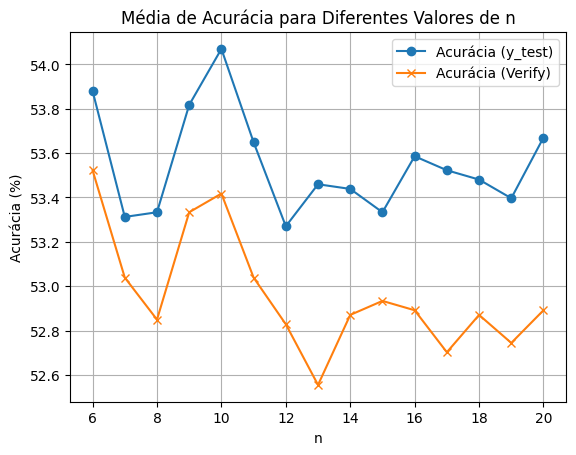

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[[f'RSI_{n}',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    f'On Balance Volume']]
    y = price_data[f'Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

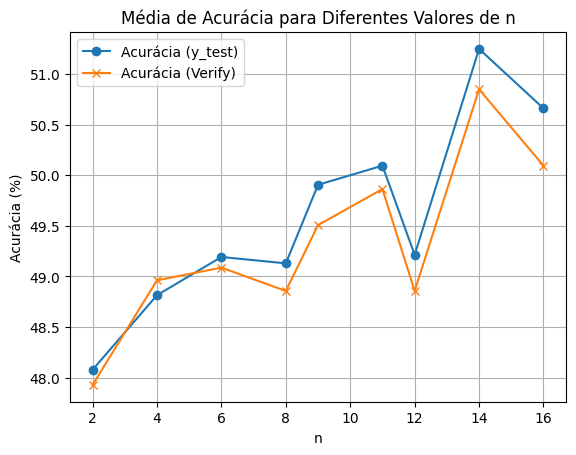

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)